In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16 #16
cpus_per_task = 2 #2
omp_num_threads = 2 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/yambo_module',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 16 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

# GW convergence analysis for AGSL5

We perform a convergence study for the GW runlevel

## HF Analysis

We do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 100
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 10x20x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on the EXXRLvcs variable while the VXCRLvcs is left to its DFT value__

__Is this the best choice?__

In [4]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_35.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_35'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_10x20-nbnds_35/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [6]:
start_band,stop_band = 25,26 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
#inp

We perform a convergence run on the EXXRLvcs parameter

In [9]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [10]:
#study.runs[2]

In [16]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of hf-G-exxrlvcs_10.0
Skip the run of hf-G-exxrlvcs_20.0
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-exxrlvcs_30.0Skip the run of
 hf-G-exxrlvcs_40.0
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of hf-G-exxrlvcs_50.0
Task [4] ended 
 


We plot the values of the gap at the $\Gamma$ point

In [17]:
gap_G = [results[r].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results]
gap_G

[2.204822, 2.203676, 2.203482, 2.2035, 2.203482]

Text(0.5, 0, 'EXXRLvcs (Ha)')

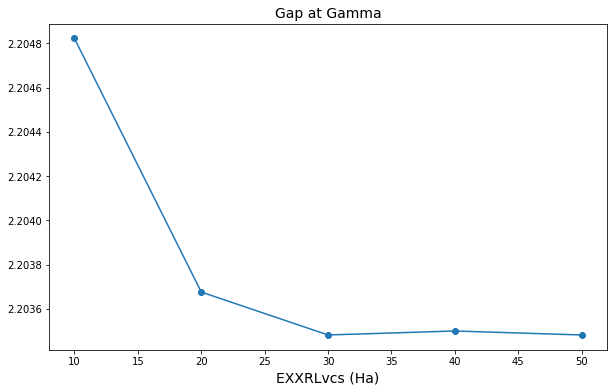

In [18]:
fig, axes = plt.subplots(figsize=(10, 6))
axes.plot(EXXRLvcs,gap_G)
axes.scatter(EXXRLvcs,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('EXXRLvcs (Ha)',size=14)

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 40 Ha

which guarantees the convergence of the HF gap at $\Gamma$ at the level of 1 meV. We ahve also checked that the same
precision is valid for the valence and conduction bands, not only for the gap.

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $\Gamma$ in function of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [19]:
start_band,stop_band = 25,26 # bands range for the computation of the HF corrections
Gamma_index = 1
RandGvec = 100
RandQpts = 5e6

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

In [20]:
kvalues = [10,15,20,25,30]

In [21]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kvalues:
    input_dir = 'DFT_analysis/kpoints_%sx%s-nbnds_35.save'%(k,2*k)
    run_dir = 'MB_analysis/kpoints_%sx%s-nbnds_35'%(k,2*k)
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 1 nodes on ismhpc (with 16 mpi and 2 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%sx%s'%(k,2*k)
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder MB_analysis/kpoints_10x20-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_15x30-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_20x40-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_25x50-nbnds_35/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_30x60-nbnds_35/SAVE already present. No operations performed.


In [23]:
#study.ids

In [24]:
#study.runs[3]

In [25]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of Skip the run ofhf-G-kpoints_15x30 
hf-G-kpoints_10x20
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_20x40
Skip the run of hf-G-kpoints_25x50
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of hf-G-kpoints_30x60
Task [4] ended 
 


In [26]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in results]
gap_G

[2.2034830000000003,
 2.136705,
 2.1199030000000003,
 2.115724,
 2.1150349999999998]

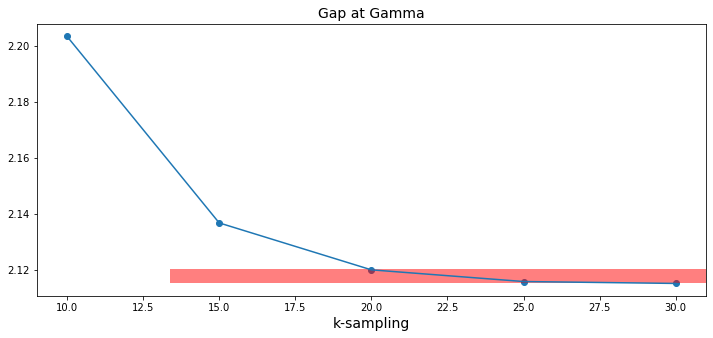

In [35]:
fig, axes = plt.subplots(figsize=(12, 5))
axes.plot(kvalues,gap_G)
axes.scatter(kvalues,gap_G)
axes.set_title('Gap at Gamma',size=14)
axes.set_xlabel('k-sampling',size=14)
#axes.hlines(gap_G[-1],10.,30,linestyles='-',color='gray',linewidth=1)
#axes.hlines(gap_G[-1]+0.005,10.,30,linestyles='-',color='gray',linewidth=1)
axes.axhspan(gap_G[-1], gap_G[-1]+0.005, xmin = 0.2,facecolor='red', alpha=0.5)

With the 20x40x1 sampling the HF gap at $\Gamma$ is converged at the level of 5 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ using the plasmon pole run level.

In [7]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


### Convergence analysis of the screening

We use the 10x20x1 k-points sampling (for computational reasons on the ism cluster) and perform a convergence analysis in the BndsRnXp and GbndRnge parameters needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

In [9]:
input_dir = 'DFT_analysis/kpoints_10x20-nbnds_500.save'
run_dir = 'MB_analysis/kpoints_10x20-nbnds_500'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

Create the folder path MB_analysis/kpoints_10x20-nbnds_500
Executing command: cd MB_analysis/kpoints_10x20-nbnds_500; p2y -I ../../DFT_analysis/kpoints_10x20-nbnds_500.save
Build the r_setup in the yambo_dir path MB_analysis/kpoints_10x20-nbnds_500


We the define the input variables common to all the runs

In [10]:
ntasks_c = 32 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,26
Gamma_index = 1
RandGvec = 100
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
#inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 2


First we run over NGsBlkXp and we set the number of bands in the response function to the 300 for a balance between computational time and a proper
check of the convergence of the G size of the response (since these variables are correlated).

The variable LongDrXp is set to the inplane value [1,1,0] 

In [11]:
NGsBlkXp = [4.0] #[4.0,6.0,8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_array_variables(LongDrXp=[1.,1.,0.])

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs'],reformat=False)
#'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])

Initialize a Dataset with 1 parallel tasks


In [14]:
#study.runs[0]

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 64 yambo -F pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300.in -J "pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300,ndbs" -C pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300
slurm submit:  cd MB_analysis/kpoints_10x20-nbnds_500 ; sbatch job_pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300.sh
computation pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300 is running...


In [46]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.799132, 0.800351, 0.797613, 0.795936],
 [0.176307, 0.17599200000000004, 0.17595700000000003, 0.175966])

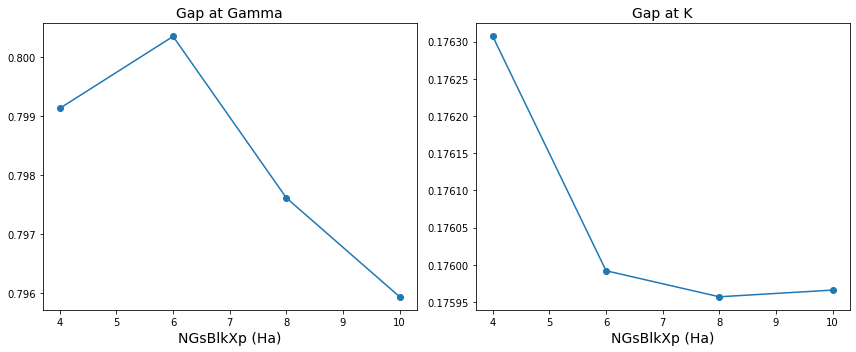

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We choose the value NGsBlkXp = 8 Ha that ensures convergence at the level of 1 meV (or better) for
both the $\Gamma$ and the K points.

Next, we perform a convergence analysis on the number of bands. Here we choose to analyze the combined 
effect of the BndsRnXp and of the GbndRnge parameters. So we iterate over both the parameters.

In [56]:
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500]] # Bands in the response function and in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands)
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 

Initialize a Dataset with 1 parallel tasks


In [54]:
#study.runs[2]

In [57]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
Task [2] ended 
 
Run the task [3] 
run command: mpirun -np 64 yambo -F pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400.in -J "pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400,ndb_rim_cutoff,ndb_hf_K,ndb_dipoles-nbnds_500,ndb_em1d-ngsblkxp_8.0-bndsrnxp_400" -C pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500 ; sbatch job_pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400.sh
computation pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400 is running...
computation pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400 ended
Run performed in 14m-54s
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-ngsb

In [58]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.797613, 0.792634, 0.789345],
 [0.17595700000000003, 0.18112499999999998, 0.18471400000000004])

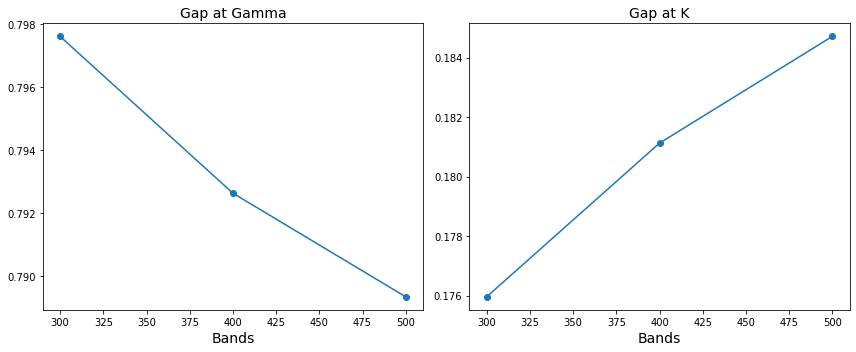

In [59]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('Bands',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('Bands',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we conclude that NGsBlkXp = 8 Ha, BndsRnXp = GbndRnge = 500 seems to ensure
 convergence within 5 meV.